# Global Average Pooling (Object Localization)

blog post:
https://alexisbcook.github.io/2017/global-average-pooling-layers-for-object-localization/4

MIT research paper(2015):
http://cnnlocalization.csail.mit.edu/Zhou_Learning_Deep_Features_CVPR_2016_paper.pdf

GitHUb Implementation:
https://github.com/alexisbcook/ResNetCAM-keras

In [1]:
from keras.applications.resnet50 import ResNet50

model = ResNet50()
model.summary()

Using TensorFlow backend.


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [2]:
model.layers[-1].get_weights()[0].shape

(2048, 1000)

 - Each of the activation maps in the output of activation_49 acts as a detector for a different pattern in the image.
 
 - Each node in the GAP output corresponds to an activation map detecting a different feature
 
 - The weights connecting the GAP layer and output layer encode each activation maps importance to the predicted outcome.
 
 - Do a linear combination of all of the activation maps weighted with the weights of the final output layer.
 
 Activation_49 has 2048 feature maps of size (7x7). The average pooling layer reduces the feature map dimensions to (1x1x2048) by taking the average of all activations in each feature map.
 
 Take all of the weights from the final predicted image category node and connect them to each output of the GAP layer (which represents a feature map)
 
 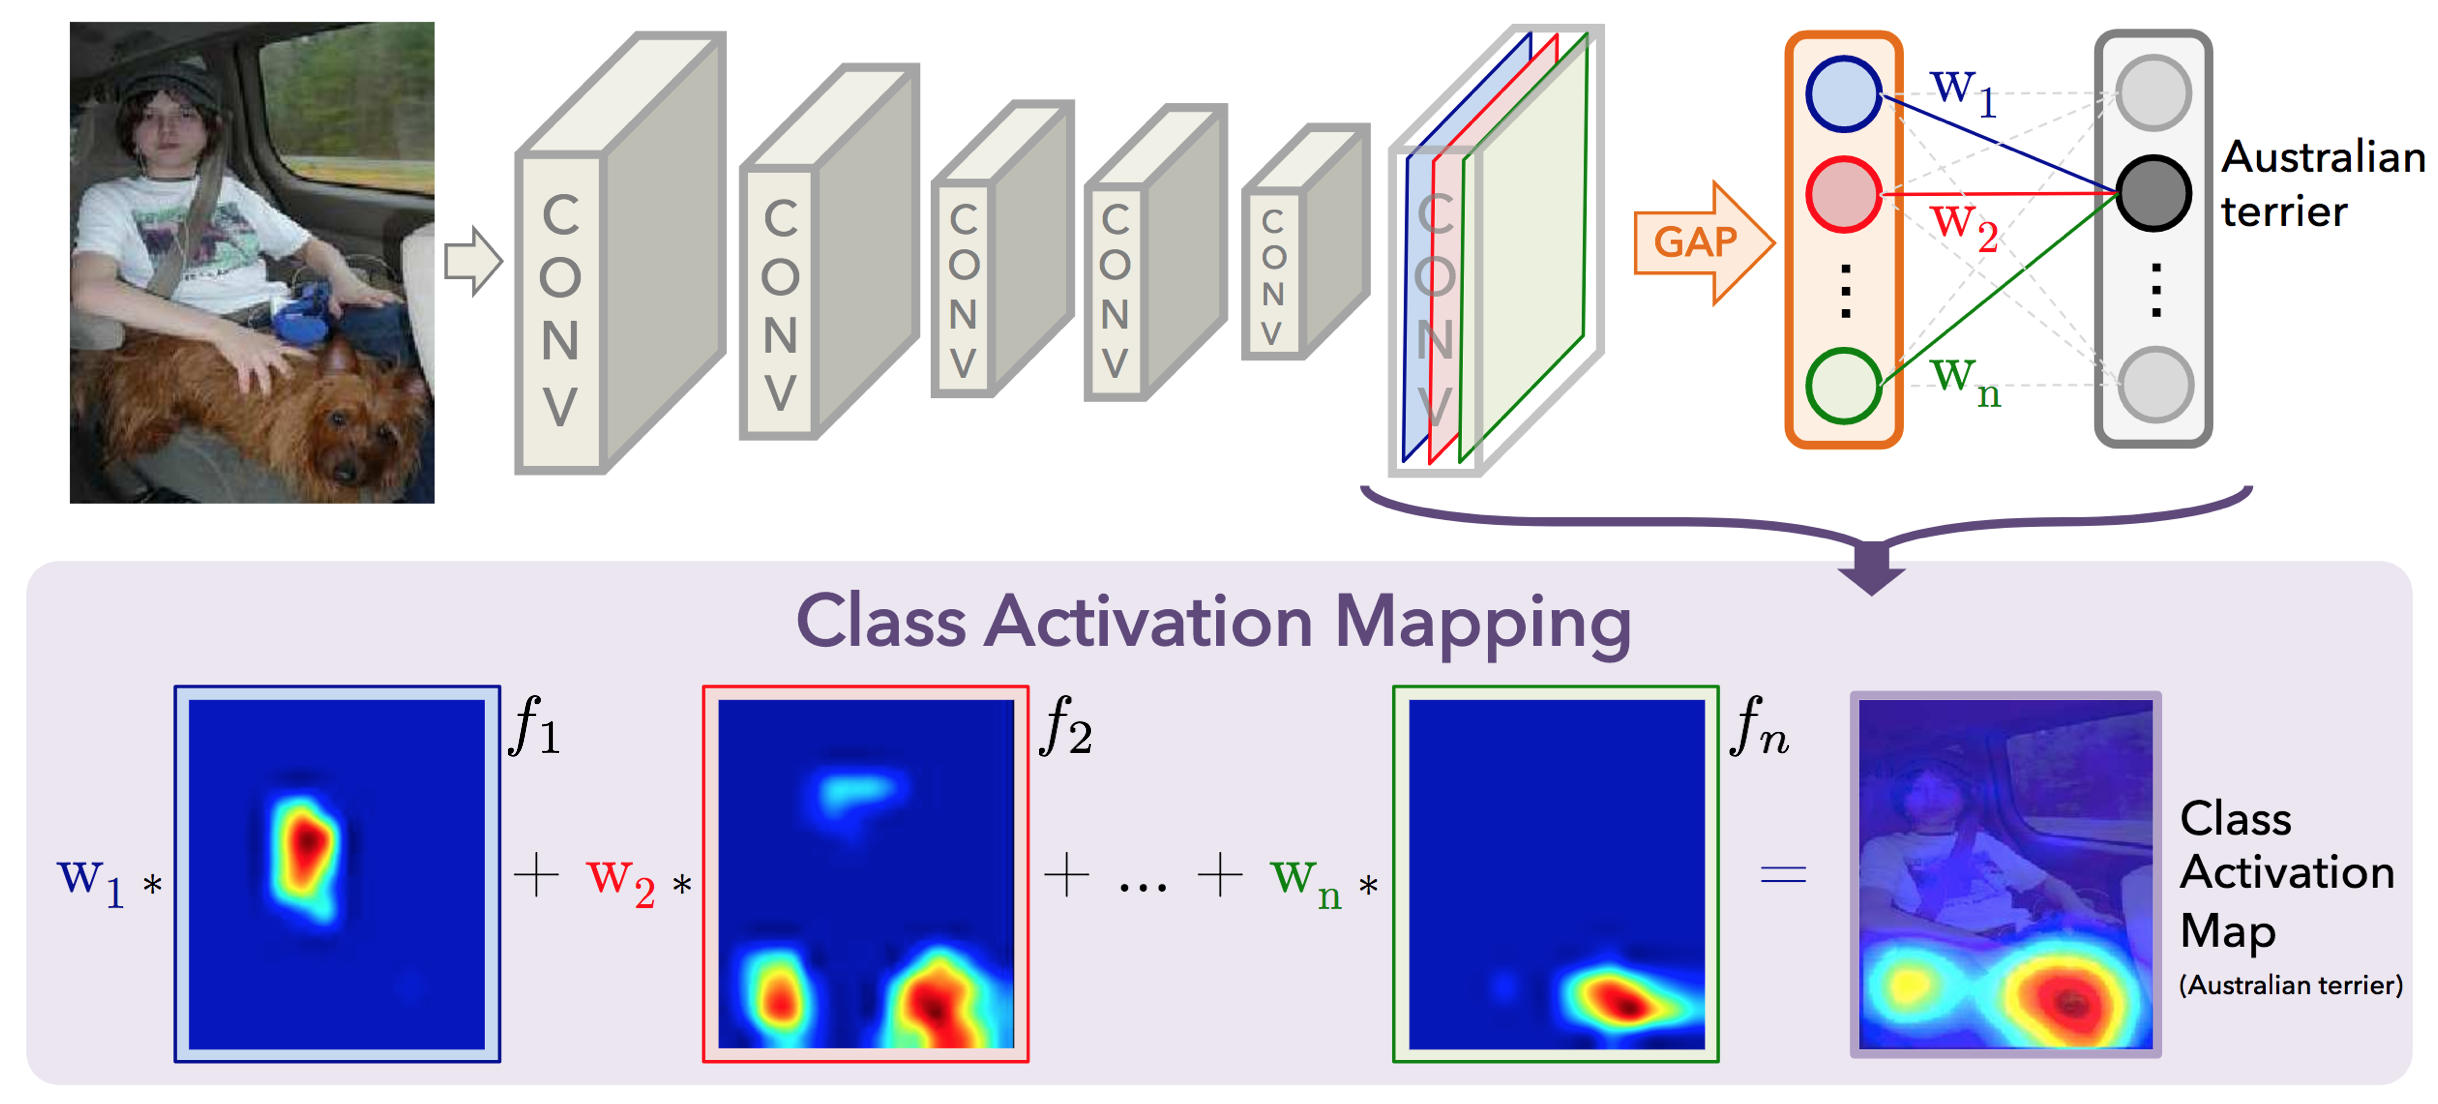

In [2]:
import numpy as np 
import matplotlib.pyplot as plt
import scipy
import cv2
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.models import Model

 - Make sure the image we load up is the correct size and format

In [3]:
def image_loader(img_path):
    #load image to RGB format
    img = image.load_img(img_path, target_size = (224,224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    # convert RGB to BGR, normalize by subtracting mean image pixel value, return 4D tensor
    return preprocess_input(x)

- Pull the weights from the final prediction layer. There will be one weight per feature map/activation of the GAP layer.
- Get the output of the last activation layer before the GAP layer

- have the built model output the ResNet prediction & the activation map of the layer preceding GAP

In [4]:
def get_ResNet():
    """ Returns ResNet Model and all weights of final resnet layer. Resnet Model outputs the activation maps
    of the last convolutional layer as well as the one hot encoded class predictions.
    Output: ResNet_model, all_amp_layer_weights"""
    model = ResNet50()
    #get fixed weights from final prediction layer!
    #since they are fixed we can make these constant and make a localization model much faster
    #come prediction time
    all_amp_layer_weights = model.layers[-1].get_weights()[0]
    ResNet_model = Model(inputs = model.inputs, outputs = (model.layers[-4].output, model.layers[-1].output))
    return ResNet_model, all_amp_layer_weights

- predict the final class and final activation maps.
- upsample final activation maps from (7x7) to (224x224) resolution
- matrix multiplication of weights for predicted class and all activation maps


NOTE: original implementation upsampled to 224x224 but the upsampling dimensions are not restricted, we add functionality to upsample to the size of the original image

In [6]:
def ResNet_CAM(img_path, model, all_amp_layer_weights):
    """
    returns the activation heatmap that  is the same size as the original image and prediction"""
    
    
    last_conv_output, pred_vec = model.predict(image_loader(img_path))
    
    #go from (1x7x7x2048) to (7x7x2048)
    last_conv_output = np.squeeze(last_conv_output)
    
    #modelprediction idx
    pred = np.argmax(pred_vec)
    
    #upsampling zooms the np array by a factor of 32 for each axis 32*7 = 224
    mat_for_mult = scipy.ndimage.zoom(last_conv_output, (32, 32, 1), order = 1)
    
    #get only the weights connecting the prediction unit and the activation map
    amp_layer_weights = all_amp_layer_weights[:, pred]
    
    #amp_layer_weight dimensions (2048x1) 
    #mat_for_mult dimensions (224x224x2048) -> (50176x 2048) squeeze so we can multiply weight vs entire map
    #dot pruduct dim (50176x2048)o(2048x1) = (50176x1)
    #reshape to image size (50176x1) -> (224x224) so we can reshow the activation map as heatmap
    
    final_output = np.dot(mat_for_mult.reshape((224*224, 2048)), amp_layer_weights).reshape((224,224))
    
    return final_output, decode_predictions(pred_vec, top =1)

In [7]:
def plot_ResNet_CAM(img_path, ax, model, all_amp_layer_weights):
    im = cv2.resize(cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB), (224, 224))
    #plot original image
    ax.imshow(im, alpha = 0.9)
    #get activation map and prediction
    CAM, pred = ResNet_CAM(img_path, model, all_amp_layer_weights)
    #overlay class activation map
    ax.imshow(CAM, cmap = "jet", alpha = 0.4)
    ax.set_title("Prediction: " + pred[0][0][1] + "     Confidence: " + str(pred[0][0][2]), size=17) 

40960/35363 [==================================] - 0s 3us/step


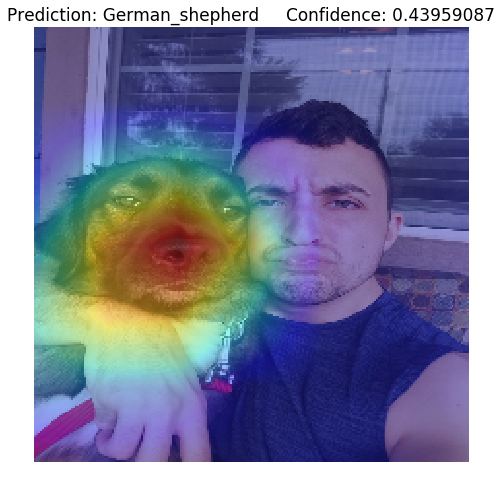

In [8]:
ResNet_model, all_amp_layer_weights = get_ResNet()
img_path = "Huckleberry.jpg"
fig, ax = plt.subplots(figsize = (8, 8))
CAM = plot_ResNet_CAM(img_path, ax, ResNet_model, all_amp_layer_weights)
plt.axis("off")
plt.show()

## Lets make one Improvement

As we said before we can make the activation map the same size as the original photo by updating the upsampling process.

This is just for asthetics on my part. The extra image size will make computational cost of the matrix multiplication stage a lot heavier.

In [9]:
def ResNet_CAM(img_path, model, all_amp_layer_weights):
    """
    returns the activation heatmap that  is the same size as the original image and prediction"""
    
    #CHANGED
    img = cv2.imread(img_path)
    img_height, img_width, channels = img.shape
    
    
    last_conv_output, pred_vec = model.predict(image_loader(img_path))
    last_conv_output = np.squeeze(last_conv_output)
    pred = np.argmax(pred_vec)
    amp_layer_weights = all_amp_layer_weights[:, pred]
    
    
    #CHANGED ZOOM TO OG PHOTO SIZE
    mat_for_mult = scipy.ndimage.zoom(last_conv_output, (img_height/7, img_width/7, 1), order = 1)
    
    
    #CHANGED
    #dot pruduct dim (img_area x 2048)o(2048 x 1) = (img_area x 1)
    #reshape to image size (img_area x 1) -> (img_height x img_width) so we can reshow the activation map as heatmap
    
    final_output = np.dot(mat_for_mult.reshape((img_height*img_width, 2048)), amp_layer_weights).reshape((img_height,img_width))
    return final_output, decode_predictions(pred_vec, top =1)

def plot_ResNet_CAM(img_path, ax, model, all_amp_layer_weights):
    im = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
    #plot original image
    ax.imshow(im, alpha = 0.9)
    #get activation map and prediction
    CAM, pred = ResNet_CAM(img_path, model, all_amp_layer_weights)
    #overlay class activation map
    ax.imshow(CAM, cmap = "jet", alpha = 0.4)
    ax.set_title("Prediction: " + pred[0][0][1] + "     Confidence: " + str(pred[0][0][2]), size=14) 

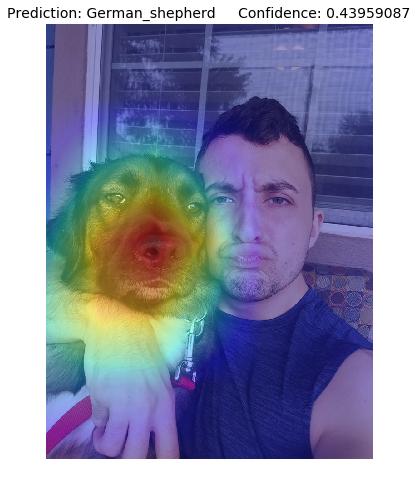

In [10]:
ResNet_model, all_amp_layer_weights = get_ResNet()
img_path = "Huckleberry.jpg"
fig, ax = plt.subplots(figsize = (8, 8))
CAM = plot_ResNet_CAM(img_path, ax, ResNet_model, all_amp_layer_weights)
plt.axis("off")
plt.show()

## Future Improvements: 
implement functionality to allow mapping of the second and third most likely class categories.

In [5]:
def ResNet_CAM(img_path, model, all_amp_layer_weights, classes = 1):
    """
    returns the activation heatmap that  is the same size as the original image and prediction"""
    
    #load in image
    img = cv2.imread(img_path)
    #get image resolution so we can resize later
    img_height, img_width, channels = 960, 720, 3
    
    #get final conv activation maps and prediction vectors
    last_conv_output, pred_vec = model.predict(image_loader(img_path))
    #reduce activation maps to 3 dimensions
    last_conv_output = np.squeeze(last_conv_output)
    
    #zoom feature maps to same resolution as OG image
    mat_for_mult = scipy.ndimage.zoom(last_conv_output, (img_height/7, img_width/7, 1), order = 1)
    
    #going to output a list of (class activation maps at full resolution, ResNet class prediction)
    output = []
    for x in range(classes):
        
        #returns indices that would sort the pred_vec array last = largest
        pred_idx = np.argsort(pred_vec)
        index = x+1
        pred  = pred_idx[-index]
        
        amp_layer_weights = all_amp_layer_weights[:, pred]
        
        
        final_output = np.dot(mat_for_mult.reshape((img_height*img_width, 2048)), amp_layer_weights).reshape((img_height,img_width))
        
        output.append((final_output, decode_predictions(pred_vec, top =classes)[0][x][1], decode_predictions(pred_vec, top =classes)[0][x][2]))
    return output

def plot_ResNet_CAM(img_path, model, all_amp_layer_weights, classes = 1):
    #read in image convert to format
    im = cv2.resize(cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB),(960,720))
    #get activation map and prediction
    prediction_pool  = ResNet_CAM(img_path, model, all_amp_layer_weights, classes = classes)
    
    for row in range(classes):
        row += row
        for col in range(2):
            plt.subplots(row, col, row*col)
            #plot original image
            plt.imshow(im, alpha = 0.9)
            if col == 1:
                #overlay class activation map 
                #Prediction_pool = [(image, class, confidence), ...]
                #row is class, Starting at row 0 which is the class with the highest confidence
                plt.imshow(prediction_pool[row][0], cmap = "jet", alpha = 0.4)
                plt.title("Prediction: " + prediction_pool[row][1] + "     Confidence: " + str(prediction_pool[row][2]), size=14) 
            else:
                plt.title("Original Image")
        

In [ ]:
ResNet_model, all_amp_layer_weights = get_ResNet()
img_path = "huckAmy.jpg"
CAM = plot_ResNet_CAM(img_path, ResNet_model, all_amp_layer_weights, classes = 1)
plt.axis("off")
plt.show()